Based on results of Milestone 5, TVAE M34_R4 is our leading model. We will compare it with OVS2019 in this notebook. 

# Importing necessary libraries

In [1]:
# Import libraries

import torch
import numpy as np

import os
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.stats
from sklearn.metrics import mean_squared_error
from scipy.stats import bartlett
from scipy.stats import ttest_ind
from pathlib import Path


# Setting seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [2]:
cwd = os.getcwd()

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
## load OVS2019 test dataset
OVS2019 = pd.read_csv(str(Path(cwd).parents[0]) + '/Step1/Real Data/OVS2019_cleaned.csv')

In [6]:
OVS2019.shape ## 22070 rows and 259 columns

(22070, 259)

In [7]:
# Total of 24 Benchmark variables
# List of 14 expenditure variables
list_expnd = ['Expenditure on Accommodation (c4.tot.new)',
              'Expenditure on F&B (c6.tot.new)',
              'Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)',
              'Expenditure on Casual Dining (c6c_2.r)',
              'Expenditure on Transport (c7.tot.new)', 
              'Expenditure on Sightseeing & Entertainment (c10.tot.new)',
              'Expenditure on Sightseeing (c10c_1.r)',
              'Expenditure on Attractions (c10c_2.r)',
              'Expenditure on Shopping (t7.m.any)',          
              'Expenditure on Healthcare & Wellness Products (t7.m.well)',
              'Expenditure on Confectionery & Food Items (t7.m.food)',
              'Expenditure on Fashion (t7.m.fash)',
              'Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth)',
              'Package Expenditure Per Person (c1b.r)']

# List of 10 categorical variables
list_cat = ['Mode of Transport (m1)',
            'Main POV - Leisure/Holiday (b13a_112)',
            'Main POV - Visiting Friends/Family (b13a_114)',
            'Main POV - Business (b13a_116)',
            'Main POV - Healthcare (b13a_117)',
            'Main POV - Education/Training/Workshop (b13a_118)',
            'Main POV - Others (b13a_119)',
            'Travel Package (c1a)',
            'Accommodation - Hotels (c4a_1, c4a_2, c4a_3)',
            'Accommodation - Others (c4a_4, c4a_5, c4a_7, c4a_8)']

In [8]:
## continuous columns
with open(str(Path(cwd).parents[0]) + '/Step1/Real Data/continuous_columns.txt',"r+")   as f:
    con_cols = f.read().splitlines()

## Load synthetic data generated by leading model (TVAE M34_R4)

In [9]:
## list all continuous variables for which 0 is meaningful
column_list = ['b10','b11','b12number_1','b12number_2','b12number_3_5','b12number_4','b12number_6','b12number_7_8','c1c','c4c_1','b12b_1','b12b_2']

In [10]:
## clean synthethid data and test data
## replace NAs back and remove non-positive/positive values
def data_cleaning(df):
    df_new = df.copy()
    for expnd in con_cols:
        if expnd + '_cat' in df.columns:
            df_new[expnd] = df_new[expnd].mask(df_new[expnd+'_cat'] == 1)
        if expnd in column_list:
            df_new[expnd] = df_new[expnd].mask(df_new[expnd] < 0)
        else:
            df_new[expnd] = df_new[expnd].mask(df_new[expnd] <= 0)
    return df_new

In [11]:
## tvae Run 4 Model 34
tvae_samples = pd.read_csv(cwd + '/Synthetic Data/tvae_model_34_PID5074_20210305_165149_sample.csv')
tvae_samples_cleaned = data_cleaning(tvae_samples)

In [12]:
tvae_samples_cleaned.shape

(9905, 293)

# 1. Visualization (KDE plots, Bar charts and Boxplots)

In [13]:
## KDE plots
def plots2(original_data, synthetic_data, list_expnd):
    
    for i in np.arange(len(list_expnd))[::2]:
        fig,ax = plt.subplots(1, 2, figsize=(16, 5))
        col1 = list_expnd[i]
        col2 = list_expnd[i+1]
        prop1 =  round(sum(original_data[col1].isna())/len(original_data[col1])*100,2)
        ax[0].set_title(col1 + " " + str(prop1) +'% NAs')
              
        sns.kdeplot(original_data[col1],shade=True, ax=ax[0], label='OVS2019')
        if len(synthetic_data[col1].unique()) > 1:
            sns.kdeplot(synthetic_data[col1],shade=True,ax=ax[0], label='Synthetic')
        ax[0].legend();
        prop2 =  round(sum(original_data[col2].isna())/len(original_data[col2])*100,2)
        ax[1].set_title(col2 + " " + str(prop2) +'% NAs')
              
        sns.kdeplot(original_data[col2],shade=True, ax=ax[1], label='OVS2019')
        if len(synthetic_data[col2].unique()) > 1:
            sns.kdeplot(synthetic_data[col2],shade=True,ax=ax[1], label='Synthetic')
        ax[1].legend();
        plt.show()

In [14]:
## Bar plots
def plots2_bar(original_data, synthetic_data, cat_cols):
    width = 0.1
    
    for i in np.arange(len(cat_cols))[::2]:
        fig,ax = plt.subplots(1, 2, figsize=(16, 5))
        col1 = cat_cols[i]
        col2 = cat_cols[i+1]
        xlab1 = np.asarray(original_data[col1].value_counts().index)
        ax[0].set_title(col1)
        ax[0].bar(xlab1,original_data[col1].value_counts(normalize=True), color='g', label='OVS2019',width=width)
        ax[0].bar(xlab1+width,synthetic_data[col1].value_counts(normalize=True), color='b', label='Synthetic Data',width=width)        
        ax[0].legend();
        xlab2 = np.asarray(original_data[col2].value_counts().index)
        ax[1].set_title(col2)
        ax[1].bar(xlab2,original_data[col2].value_counts(normalize=True), color='g', label='OVS2019',width=width)
        ax[1].bar(xlab2+width,synthetic_data[col2].value_counts(normalize=True), color='b', label='Synthetic Data',width=width)        
        ax[1].legend();
        plt.show()

In [15]:
# boxplot
def boxplots2(original_data, synthetic_data, list_expnd):
    
    for i in np.arange(len(list_expnd))[::2]:
        fig,ax = plt.subplots(1, 2, figsize=(16, 5))
        col1 = list_expnd[i]
        col2 = list_expnd[i+1]
        prop1 = round(sum(original_data[col1].isna())/len(original_data[col1])*100,2)
        ax[0].set_title(col1 + " " + str(prop1) +'% NAs')
        df1 = pd.DataFrame({'OVS2019': original_data[col1],
                           'Synthetic Data':synthetic_data[col1]})
        sns.boxplot(x="variable", y="value", data=pd.melt(df1),ax=ax[0],showmeans=True, meanprops={"marker":"s",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black"})

        prop2 = round(sum(original_data[col2].isna())/len(original_data[col2])*100,2)
        ax[1].set_title(col2 + " " + str(prop2) +'% NAs')
              
        df2 = pd.DataFrame({'OVS2019': original_data[col2],
                           'Synthetic Data': synthetic_data[col2]})
        sns.boxplot(x="variable", y="value", data=pd.melt(df2),ax=ax[1],showmeans=True,meanprops={"marker":"s",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black"})
        plt.show()

## 1.1 KDE plots for OVS2019 vs Synthetic data under leading model (continuous benchmark variables)

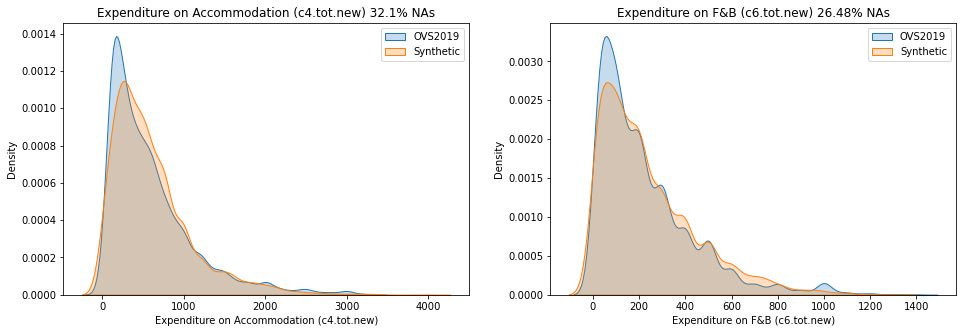

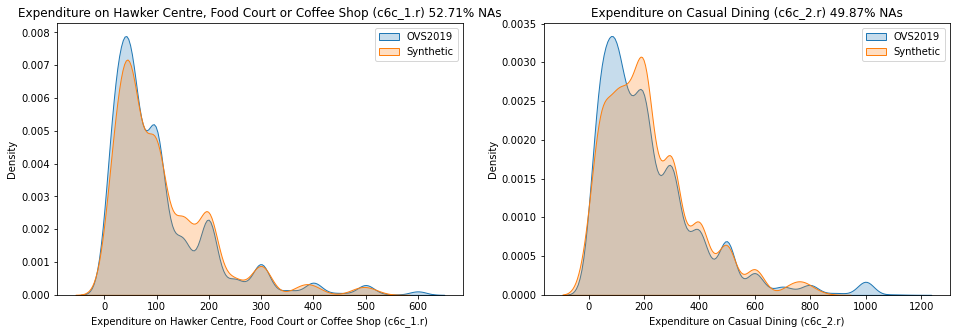

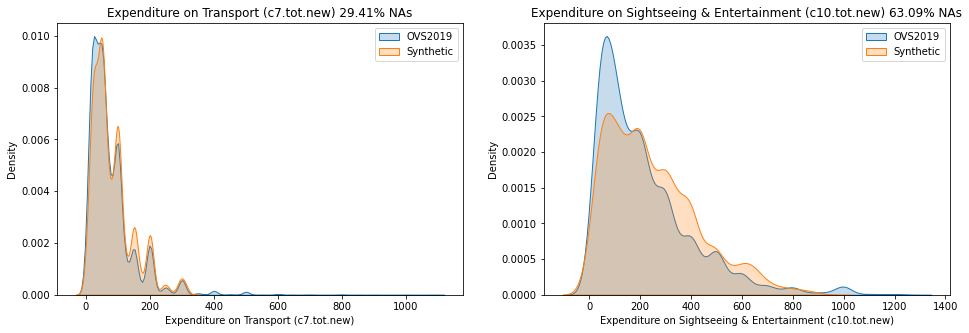

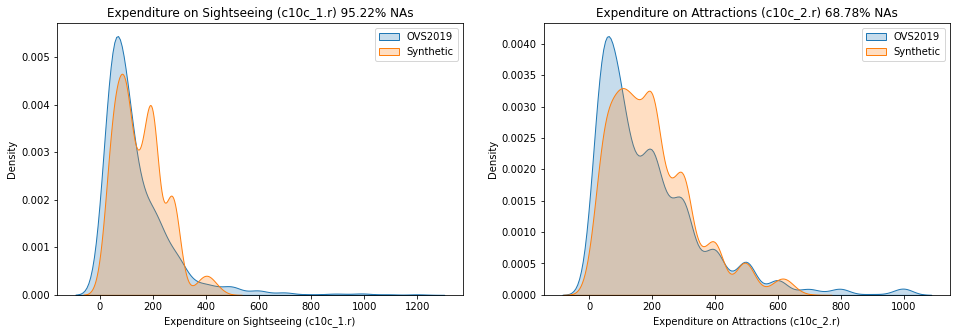

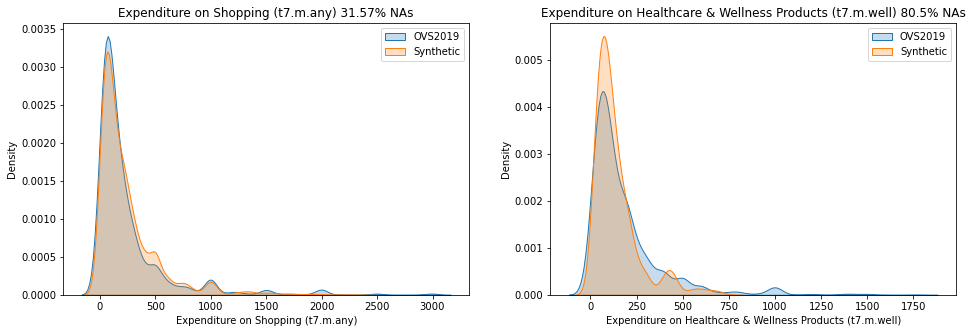

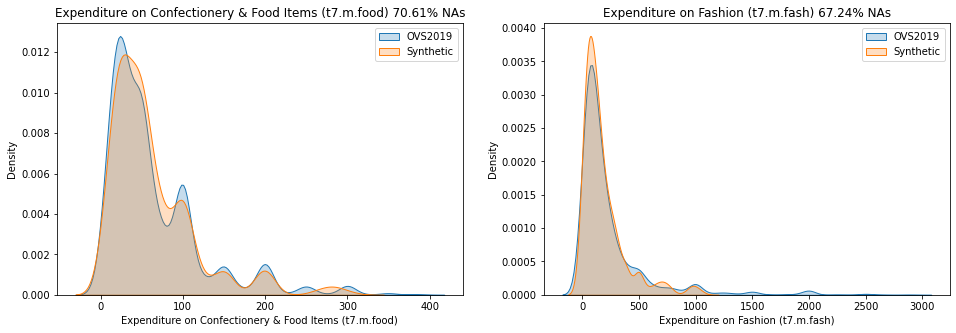

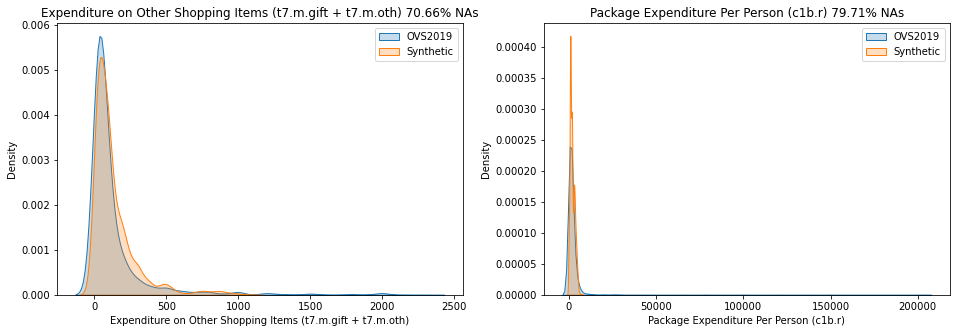

In [16]:
plots2(OVS2019,tvae_samples_cleaned,list_expnd)

## 1.2 Boxplots for OVS2019 vs Synthetic data under leading model (continuous benchmark variables)

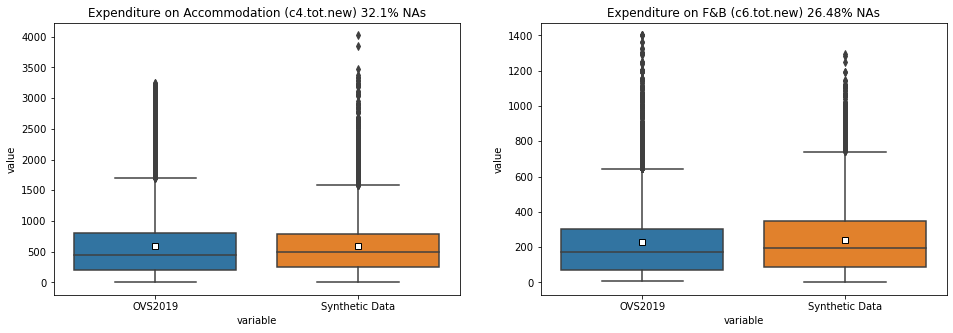

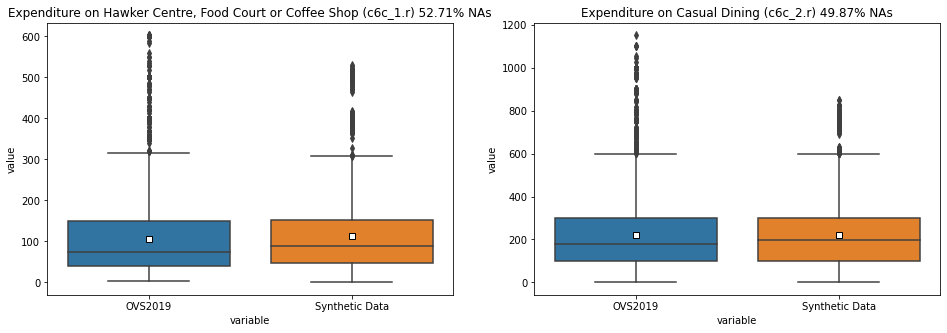

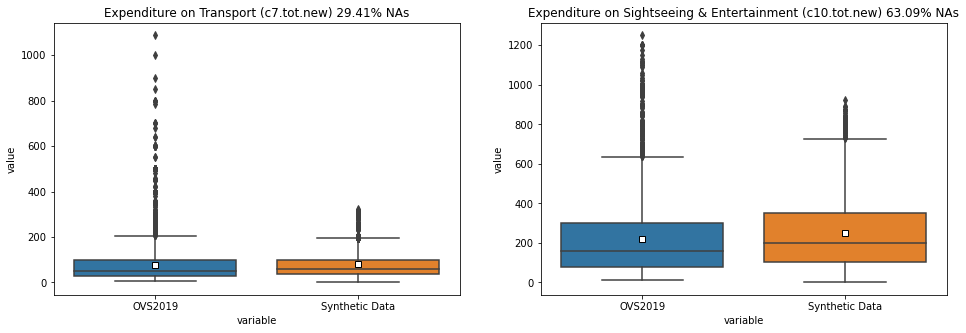

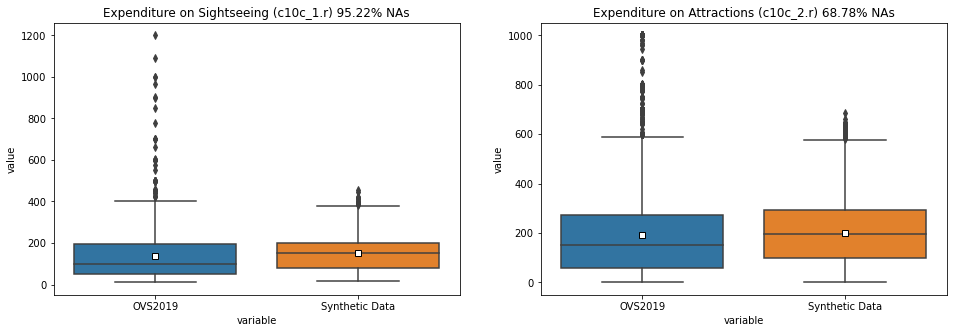

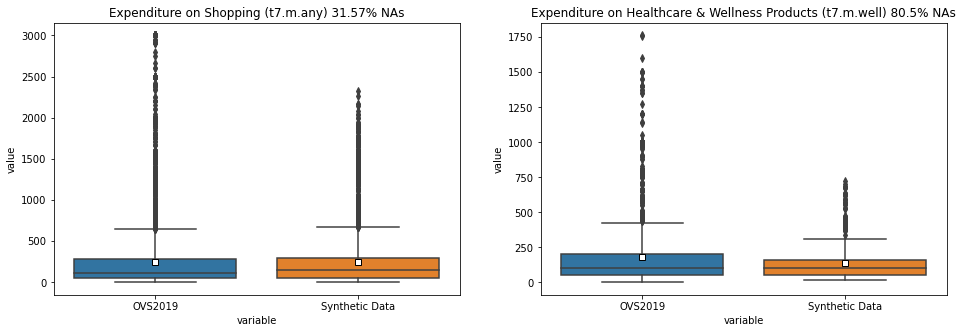

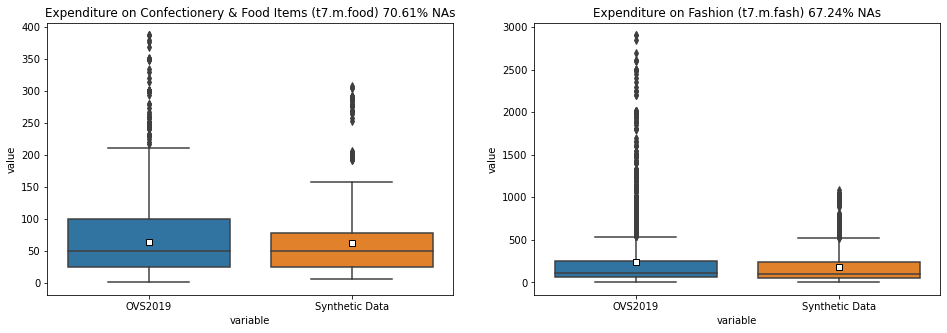

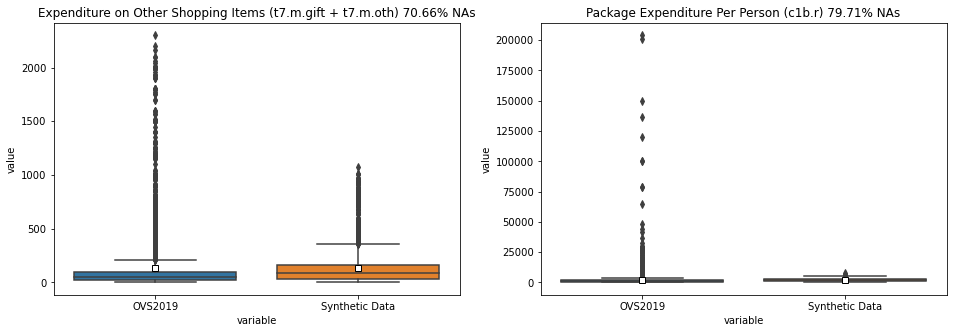

In [17]:
boxplots2(OVS2019,tvae_samples_cleaned,list_expnd)

## 1.3 Bar charts for OVS2019 vs Synthetic data under leading model (categorical benchmark variables)¶

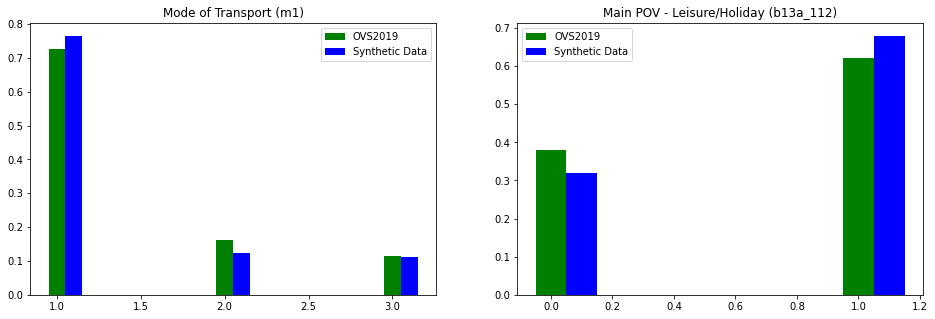

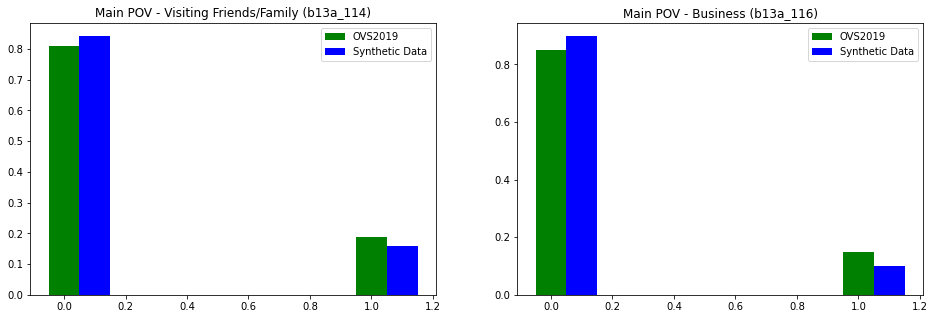

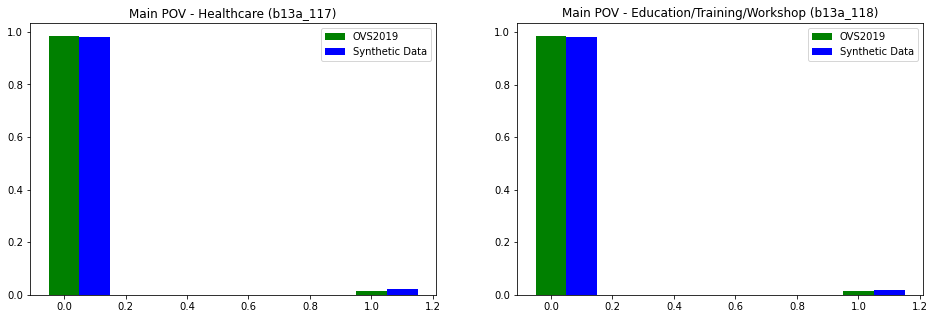

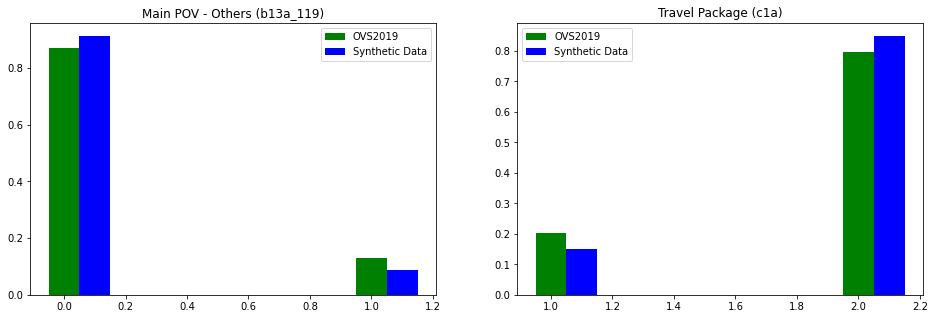

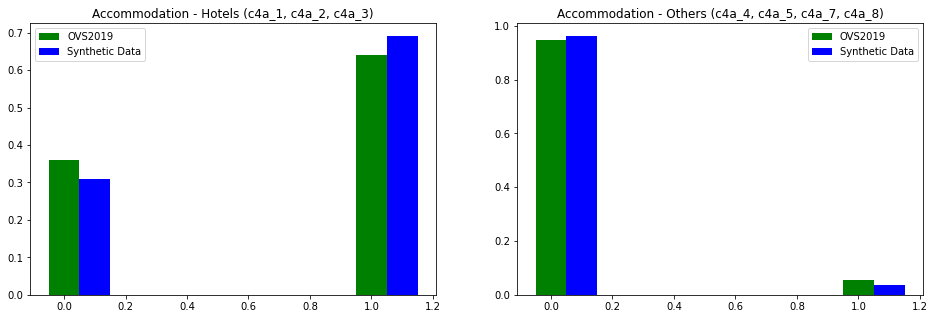

In [18]:
plots2_bar(OVS2019,tvae_samples_cleaned,list_cat)

# 2. Compute statistics

In [19]:
# Compute statistics for continuous benchmarks
def continuous_statistics(df, list_cols):
    result_df = df[list_cols].describe()
    result_df = result_df.transpose()
    result_df['count'] = result_df['count'].astype(int)
        
    # Compute the standard error of the mean
    result_df.insert(loc = 2, column = 'Standard Error', value = df[list_cols].sem())
    
    # Compute 95% Confidence Interval (assuming normal distribution)
    result_df.loc[:,'Lower 95% CI'], result_df.loc[:,'Upper 95% CI'] = stats.norm.interval(0.95, loc=result_df.loc[:,'mean'], scale=result_df.loc[:,'Standard Error'])
    
    result_df.rename(columns = {'count': 'Count', 'mean': 'Mean', 'std': 'Standard Deviation', '50%': 'Median'}, inplace=True)
    return result_df

In [20]:
# Compute statistics for categorical benchmarks
def categorical_statistics(df, list_cols):
    result_df = df[list_cols].melt(var_name='Variable', value_name='Value').groupby(['Variable', 'Value']).size().to_frame(name='Count')
    result_df['Proportion'] = result_df['Count'].div(result_df['Count'].sum(level=0), level=0)
    result_df['np>5'] = (result_df['Count'] * result_df['Proportion']) > 5
    result_df['nq>5'] = (result_df['Count'] * (1 - result_df['Proportion'])) > 5
    result_df['Standard Error'] = np.sqrt(result_df['Proportion'] * (1-result_df['Proportion']) / result_df['Count'].sum(level=0))
    result_df['Lower 95% CI'] = result_df['Proportion'] - 1.96 * result_df['Standard Error']
    result_df['Upper 95% CI'] = result_df['Proportion'] + 1.96 * result_df['Standard Error']
    return result_df

In [21]:
syn_cat_stat = categorical_statistics(tvae_samples_cleaned,list_cat)
syn_con_stat = continuous_statistics(tvae_samples_cleaned,list_expnd)

In [22]:
real_cat_stat = categorical_statistics(OVS2019,list_cat)
real_con_stat = continuous_statistics(OVS2019,list_expnd)

In [23]:
con_stat_df =  pd.DataFrame({'Real Mean': real_con_stat['Mean'],
                   'Synthetic Mean':syn_con_stat['Mean'],
                   'Absolute Difference':abs(real_con_stat['Mean']-syn_con_stat['Mean']),
                        'Real Std': real_con_stat['Standard Deviation'],
                        'Synthetic Std': syn_con_stat['Standard Deviation']})

## 2.1 Compare mean and standard deviation for continuous variables

In [24]:
con_stat_df

,Real Mean,Synthetic Mean,Absolute Difference,Real Std,Synthetic Std
Expenditure on Accommodation (c4.tot.new),596.336926,601.002544,4.665617,533.202349,497.609111
Expenditure on F&B (c6.tot.new),228.374552,239.313615,10.939062,213.626732,208.265428
"Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r)",106.698804,112.138119,5.439315,101.981943,95.510266
Expenditure on Casual Dining (c6c_2.r),219.872910,221.230032,1.357122,186.099066,163.352387
Expenditure on Transport (c7.tot.new),77.013131,82.208196,5.195065,74.217482,63.776141
Expenditure on Sightseeing & Entertainment (c10.tot.new),217.498462,248.257830,30.759368,190.990054,179.282383
Expenditure on Sightseeing (c10c_1.r),139.568289,153.247138,13.678848,137.381950,90.804090
Expenditure on Attractions (c10c_2.r),193.617781,199.827964,6.210182,172.046390,133.147123
Expenditure on Shopping (t7.m.any),251.433666,243.733881,7.699786,374.774685,287.079559
Expenditure on Healthcare & Wellness Products (t7.m.well),183.050139,138.188709,44.861430,209.867615,123.777338


## 2.2 Compare proportions for categorical variables

In [25]:
cat_stat_df =  pd.DataFrame({'Real Proportion': real_cat_stat['Proportion'],
                   'Synthetic Proportion':syn_cat_stat['Proportion'],
                   'Absolute Difference':abs(real_cat_stat['Proportion']-syn_cat_stat['Proportion'])})

In [26]:
cat_stat_df

Real Proportion  \
Variable                                           Value                    
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0             0.359583   
                                                   1             0.640417   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0             0.946760   
                                                   1             0.053240   
Main POV - Business (b13a_116)                     0             0.849615   
                                                   1             0.150385   
Main POV - Education/Training/Workshop (b13a_118)  0             0.985591   
                                                   1             0.014409   
Main POV - Healthcare (b13a_117)                   0             0.984005   
                                                   1             0.015995   
Main POV - Leisure/Holiday (b13a_112)              0             0.380018   
                                                   1             0.619982   
Main POV - Others (b13a_119)                       0             0.871726   
                                                   1             0.128274   
Main POV - Visiting Friends/Family (b13a_114)      0             0.810557   
                                                   1             0.189443   
Mode of Transport (m1)                             1             0.725283   
                                                   2             0.161033   
                                                   3             0.113684   
Travel Package (c1a)                               1             0.202945   
                                                   2             0.797055   

                                                          Synthetic Proportion  \
Variable                                           Value                         
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0                  0.308733   
                                                   1                  0.691267   
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0                  0.962544   
                                                   1                  0.037456   
Main POV - Business (b13a_116)                     0                  0.899041   
                                                   1                  0.100959   
Main POV - Education/Training/Workshop (b13a_118)  0                  0.982736   
                                                   1                  0.017264   
Main POV - Healthcare (b13a_117)                   0                  0.979001   
                                                   1                  0.020999   
Main POV - Leisure/Holiday (b13a_112)              0                  0.320848   
                                                   1                  0.679152   
Main POV - Others (b13a_119)                       0                  0.913882   
                                                   1                  0.086118   
Main POV - Visiting Friends/Family (b13a_114)      0                  0.842605   
                                                   1                  0.157395   
Mode of Transport (m1)                             1                  0.764866   
                                                   2                  0.122261   
                                                   3                  0.112872   
Travel Package (c1a)                               1                  0.151035   
                                                   2                  0.848965   

                                                          Absolute Difference  
Variable                                           Value                       
Accommodation - Hotels (c4a_1, c4a_2, c4a_3)       0                 0.050850  
                                                   1                 0.050850  
Accommodation - Others (c4a_4, c4a_5, c4a_7, c4... 0                 0.015784  

## 2.3 Compare coefficient of variation

In [27]:
def COV(data:pd.DataFrame,list_expnd=tuple()):
    result_list = []
    for col in list_expnd:
        result_list.append(data[col]._get_numeric_data().std()/data[col]._get_numeric_data().mean())
    return result_list

In [28]:
COV_df = pd.DataFrame({'Variable':list_expnd,
                      'Real COV':COV(OVS2019,list_expnd),
                      'Synthetic COV': COV(tvae_samples_cleaned,list_expnd)})

In [29]:
COV_df

,Variable,Real COV,Synthetic COV
0,Expenditure on Accommodation (c4.tot.new),0.894129,0.827965
1,Expenditure on F&B (c6.tot.new),0.935423,0.870262
2,"Expenditure on Hawker Centre, Food Court or Co...",0.955793,0.851720
3,Expenditure on Casual Dining (c6c_2.r),0.846394,0.738383
4,Expenditure on Transport (c7.tot.new),0.963699,0.775788
5,Expenditure on Sightseeing & Entertainment (c1...,0.878121,0.722162
6,Expenditure on Sightseeing (c10c_1.r),0.984335,0.592534
7,Expenditure on Attractions (c10c_2.r),0.888588,0.666309
8,Expenditure on Shopping (t7.m.any),1.490551,1.177840
9,Expenditure on Healthcare & Wellness Products ...,1.146503,0.895712


## 2.4 Calculate KLD values

In [30]:
def discrete_probs(column, unique_list):
    # find probability in the order of unique_list
    column = pd.Series(column)
    counts = column.value_counts()
    probs = []
    total_length = len(column)
    for i in unique_list:
        val = 0
        if i in counts.index:
            val = counts[i]
        probs.append(val/total_length)

    return np.array(probs)

# KL-divergence formula
def kl_divergence(p, q):
    p[p < 1e-12] = 1e-12
    q[q < 1e-12] = 1e-12
    a = np.log(p)
    b = np.log(q)
    return np.sum(p * (a - b))

###For continuous variables:
def ecdf(x):
    x = np.sort(x)
    u, c = np.unique(x, return_counts=True) 
    n = len(x)
    y = (np.cumsum(c) - 0.5)/n 
    def interpolate_(x_): 
        yinterp = np.interp(x_, u, y, left=0.0, right=1.0)
        return yinterp
    return interpolate_
def cumulative_continuous_kl(x,y,fraction=0.5):
    dx = np.diff(np.sort(np.unique(x))) 
    dy = np.diff(np.sort(np.unique(y)))
    ex = np.min(dx)
    ey = np.min(dy)
    e = np.min([ex,ey])*fraction 
    n = len(x)
    P = ecdf(x)
    Q = ecdf(y)
    p = P(x) - P(x-e)
    q = Q(x) - Q(x-e)
    p[p < 1e-12] = 1e-12
    q[q < 1e-12] = 1e-12
    KL = abs((1./n)*np.sum(np.log(p/q))-1) 
    return KL

In [31]:
def KLD(real, fake, discrete_columns):
    KLD = []
    for column in fake.columns:
        column_fake = fake[column].dropna().values
        column_real = real[column].dropna().values
        if column in discrete_columns:
            # find list of all unique values
            unique_list = []
            arrs = [np.unique(column_fake), np.unique(column_real)]
            for arr in arrs:
                for val in arr:
                    if val not in unique_list:
                        unique_list.append(val)
            # find probabilities of values according to order in unique_list
            fake_prob = discrete_probs(column_fake, unique_list)
            real_prob = discrete_probs(column_real, unique_list)
            KLD.append((kl_divergence(fake_prob, real_prob)+kl_divergence(real_prob,fake_prob)/2))
        else:
            # check whether indicator columns exist
            if column + '_cat' in fake.columns:
                column_fake = column_fake[fake[column + '_cat'] == 0]
                column_real = column_real[real[column + '_cat'] == 0]
                ## list all continuous variables for which 0 is meaningful
                column_list = ['b10','b11','b12number_1','b12number_2','b12number_3_5',
                               'b12number_4','b12number_6','b12number_7_8','c1c','c4c_1','b12b_1','b12b_2']
                if column in column_list:
                    column_fake = column_fake[column_fake >= 0]
                    column_real = column_real[column_real >= 0]
                else:
                    column_fake = column_fake[column_fake > 0]
                    column_real = column_real[column_real > 0]
                if len(column_fake) >= 1000 and len(column_real) >= 1000:
                    KLD.append((cumulative_continuous_kl(column_fake, column_real)+cumulative_continuous_kl(column_real, column_fake))/2)
                else:
                    KLD.append(np.nan)
            else:
                KLD.append((cumulative_continuous_kl(column_fake, column_real)+cumulative_continuous_kl(column_real, column_fake))/2)
    return np.array(KLD)

In [32]:
kld = pd.DataFrame({'Variable':list_expnd+list_cat})
kld['KLD value'] = np.round_(KLD(OVS2019[list_expnd+list_cat], tvae_samples_cleaned[list_expnd+list_cat], list_cat),4)

In [33]:
kld

,Variable,KLD value
0,Expenditure on Accommodation (c4.tot.new),1.5311
1,Expenditure on F&B (c6.tot.new),2.5060
2,"Expenditure on Hawker Centre, Food Court or Co...",2.8507
3,Expenditure on Casual Dining (c6c_2.r),2.8298
4,Expenditure on Transport (c7.tot.new),3.0594
5,Expenditure on Sightseeing & Entertainment (c1...,2.2335
6,Expenditure on Sightseeing (c10c_1.r),1.5708
7,Expenditure on Attractions (c10c_2.r),2.4098
8,Expenditure on Shopping (t7.m.any),2.6974
9,Expenditure on Healthcare & Wellness Products ...,2.5057


## 2.5 Check overlapping of 95% CI

In [34]:
cmap = plt.get_cmap("tab10")

In [35]:
import copy
def plot_CI(real: pd.DataFrame, fake: pd.DataFrame, cont=True):
    col =  plt.get_cmap("tab10")

    if cont:
        for i in np.arange(real.shape[0])[::2]:
            fig,ax = plt.subplots(1, 2, figsize=(12, 1))
            for k in np.arange(2): 
                    ax[k].set_ylim([0.9,1.7])
                    ax[k].set_title(real.index[i+k],fontsize=10)
                    ax[k].errorbar(x=real['Mean'].values[i+k], y=1, xerr=1.96*real['Standard Error'].values[i+k],fmt='D', color='g',label='Real Data')
                    ax[k].axvline(x=real['Lower 95% CI'].values[i+k],linestyle='--',color='red')
                    ax[k].axvline(x=real['Upper 95% CI'].values[i+k],linestyle='--',color='red')
                    ax[k].errorbar(x=fake['Mean'].values[i+k],y=1+0.1, xerr=1.96*fake['Standard Error'].values[i+k], fmt='o',alpha=.3, label='Synthetic Data')
        handles, labels = ax[1].get_legend_handles_labels()
        ax[1].legend(handles,labels,bbox_to_anchor=(1.05, 1.02, 1., .102), handlelength=2, loc='upper right',ncol=1, mode="expand", borderaxespad=0.)

    else:
        for i in np.arange(real.shape[0])[::3]:
            fig,ax = plt.subplots(1, 3, figsize=(14, 1))
            for k in np.arange(3):   
                    ax[k].set_ylim([0.9,1.7])
                    ax[k].set_title(real.index[i+k],fontsize=8)
                    ax[k].errorbar(x=real['Proportion'].values[i+k], y=1, xerr=1.96*real['Standard Error'].values[i+k],fmt='D', color='g',label='Real Data')
                    ax[k].axvline(x=real['Lower 95% CI'].values[i+k],linestyle='--',color='red')
                    ax[k].axvline(x=real['Upper 95% CI'].values[i+k],linestyle='--',color='red')
                    ax[k].errorbar(x=fake['Proportion'].values[i+k],y=1+0.1, xerr=1.96*fake['Standard Error'].values[i+k], fmt='o',alpha=.3, label='Synthetic Data')
        
        lines, labels = ax[2].get_legend_handles_labels()
        ax[2].legend(lines,labels,bbox_to_anchor=(1.05, 1.02, 1., .102),handlelength=4,loc='upper right',ncol=1, mode="expand", borderaxespad=0.)

    plt.show()

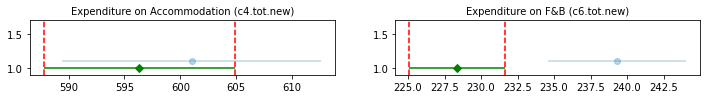

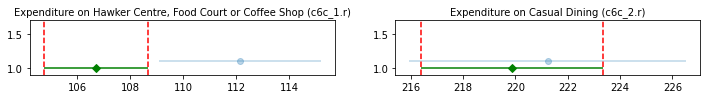

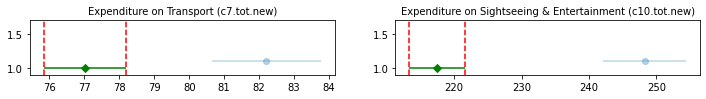

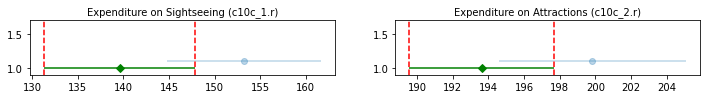

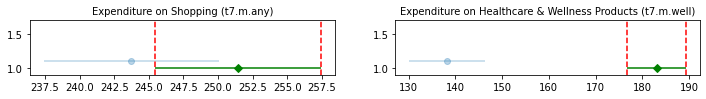

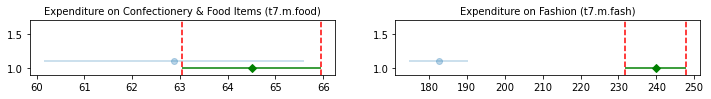

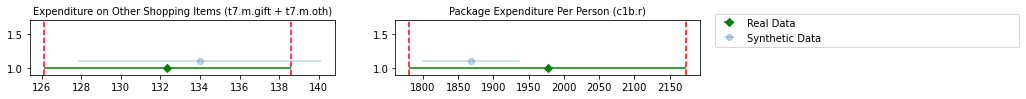

In [36]:
# Continuous variables
plot_CI(real_con_stat,fake = syn_con_stat,cont=True)

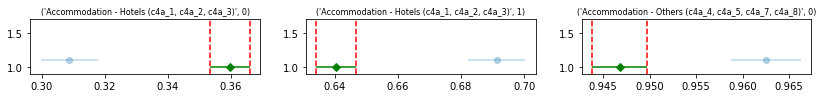

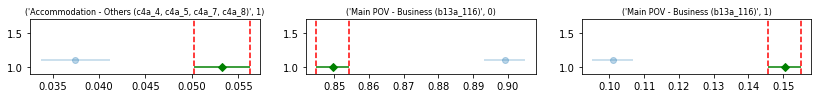

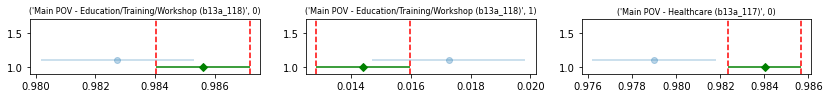

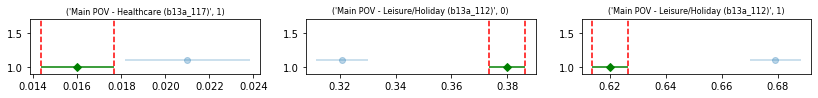

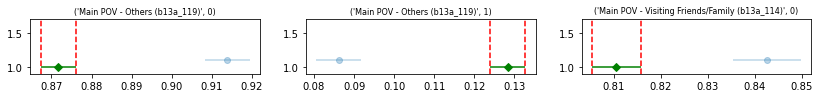

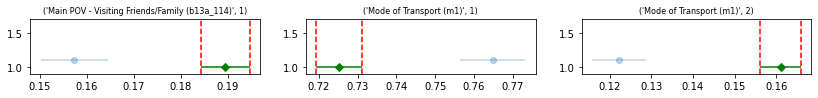

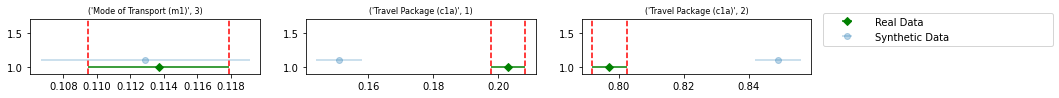

In [37]:
# categorical variables
plot_CI(real_cat_stat,fake = syn_cat_stat,cont=False)

In [38]:
def check_overlap(real,  fake):
    count = 0
    for i in np.arange(real.shape[0]):
        if real.iloc[i]['Upper 95% CI']<fake.iloc[i]['Lower 95% CI'] or real.iloc[i]['Lower 95% CI']>fake.iloc[i]['Upper 95% CI']:
            print( "Row" + str(i) + ": No")
        else:
            print("Row" + str(i)+": Yes")
            count +=1
    return count

In [39]:
num_overlap = check_overlap(real_con_stat,syn_con_stat)
print("Number of Yes:" + str(num_overlap))

Row0: Yes
Row1: No
Row2: No
Row3: Yes
Row4: No
Row5: No
Row6: Yes
Row7: Yes
Row8: Yes
Row9: No
Row10: Yes
Row11: No
Row12: Yes
Row13: Yes
Number of Yes:8


In [40]:
num_overlap = check_overlap(real_cat_stat,syn_cat_stat)
print("Number of Yes:" + str(num_overlap))

Row0: No
Row1: No
Row2: No
Row3: No
Row4: No
Row5: No
Row6: Yes
Row7: Yes
Row8: No
Row9: No
Row10: No
Row11: No
Row12: No
Row13: No
Row14: No
Row15: No
Row16: No
Row17: No
Row18: Yes
Row19: No
Row20: No
Number of Yes:3


## 2.6 T-test

In [41]:
count = 0
for i in list_expnd:
    ori = OVS2019[i].dropna().values
    syn = tvae_samples_cleaned[i].dropna().values
    if bartlett(ori,syn)[1] > 0.05:
        p = ttest_ind(ori,syn,equal_var = True,nan_policy='omit')[1]
    else:
        p = ttest_ind(ori,syn,equal_var = False,nan_policy='omit')[1]
    print("p-value of variable " +str(i)+" is: " +str(round(p,4)))
    if p >=0.05:
        count +=1
print('Number of variables which do not reject H0: '+str(count))

p-value of variable Expenditure on Accommodation (c4.tot.new) is: 0.5246
p-value of variable Expenditure on F&B (c6.tot.new) is: 0.0002
p-value of variable Expenditure on Hawker Centre, Food Court or Coffee Shop (c6c_1.r) is: 0.0034
p-value of variable Expenditure on Casual Dining (c6c_2.r) is: 0.6741
p-value of variable Expenditure on Transport (c7.tot.new) is: 0.0
p-value of variable Expenditure on Sightseeing & Entertainment (c10.tot.new) is: 0.0
p-value of variable Expenditure on Sightseeing (c10c_1.r) is: 0.0234
p-value of variable Expenditure on Attractions (c10c_2.r) is: 0.0668
p-value of variable Expenditure on Shopping (t7.m.any) is: 0.0824
p-value of variable Expenditure on Healthcare & Wellness Products (t7.m.well) is: 0.0
p-value of variable Expenditure on Confectionery & Food Items (t7.m.food) is: 0.3008
p-value of variable Expenditure on Fashion (t7.m.fash) is: 0.0
p-value of variable Expenditure on Other Shopping Items (t7.m.gift + t7.m.oth) is: 0.7162
p-value of variabl